### <font color= 'white'> S&P 500 PostCovid *Optimizations & ML models*<font> 

##### [![S&P500-PostCovid_ML](https://img.shields.io/badge/Repository-S&P500--PostCovid--ML-020521?style=flat-square&logo=github&logoColor=white)](https://mango-dune-07a8b7110.1.azurestaticapps.net/?repo=EstebanMqz%2FSP500-Risk-Optimized-Portfolios-PostCovid-ML)

##### <font color= 'lightblue'> *Introduction.* <font>

<font color= 'white'> 
Time series modelling is a powerful forecast tool and the stock market tends to be an interesting example because statistical estimators are of special interest.<br> 
They can be used to predict variables, their interaction with other variables and for efficient decision-making purposes with less human intervention.<br>

- Government
- Banking
- Insurance
- Energy
- Healthcare
- Telecommunications
- Retail
- Education

##### <font color= 'lightblue'> *Objective.* <font>

<font color= 'white'>

In this project, estimator parameters are obtained from $X_i\in [X_1,X_{500}]$ in the $S\&P500$ in order to analyze data individually and if a pattern is to be detected for $X_{P{_{R{max_{j}}}}}$ during $t_1,t_2,..t_n$.<br>
This is possible through the weight optimizations of $X_{P{_{R_{j}}}}$ and the selection of $X_{P{_{R{max_{j}}}}}$ from $X_i\in [X_1,X_{500}]$.<br>
Finally, a ML model is trained from $X_{P{_{R{max_{j}}}}}$ and tested with $X_{P_{{R{max_{j}}}_{(t+1, t+2,..+t+n)}}}$.

### <font color= 'lightblue'> 0. Requirements. <font>

##### <font color= 'lightblue'> 0.1 <u> Load Dependencies: </u><font>

In [1]:
import functions as fn
import data as dt
import visualizations as vs 

##### <font color= 'lightblue'> 0.2 <u> Install Libs. & Modules: </u><font>

<span style='color:green'> Project Creators: <span> 

Create `requirements.txt` file:

<span style='color:gray'> *Skip to `requirements.txt` installation if you are not interested in contributing to the project.* <font>

In [ ]:
docstring = """
# -- -------------------------------------------------------------------------------------- -- # 
# -- project: S&P500-Risk-Optimized-Portfolios-PostCovid-ML                                 -- # 
# -- script: requirements.txt: txt file to download Python modules for execution            -- # 
# -- author: EstebanMqz                                                                     -- # 
# -- license: CC BY 3.0                                                                     -- # 
# -- repository: SP500-Risk-Optimized-Portfolios-PostCovid-ML/blob/main/requirements.txt    -- #                                  
# -- -------------------------------------------------------------------------------------- -- # 
\n
"""

path = fn.get_requirements(docstring)

<span style='color:red'> Project Users: <span>

Install packages in `requirements.txt` file: <br>

In [ ]:
fn.library_install("requirements.txt")

##### <font color= 'lightblue'> 0.3 <u> Load Libraries & Modules </u><font>

In [2]:
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None
              ,"display.max_colwidth", None, "display.width", None)

import matplotlib
import matplotlib.pyplot as plt
plt.style.use("dark_background")
%matplotlib inline

import scipy
import scipy.stats as st
from scipy import optimize
from scipy.optimize import minimize

import sklearn
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV 
from sklearn import metrics

from yahoofinancials import YahooFinancials 
from tabulate import tabulate
import IPython.display as d
import IPython.core.display

import datetime 
import time

from io import StringIO
from fitter import Fitter, get_common_distributions, get_distributions 
import logging
import ast

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning)

### <font color= 'lightblue'> 1. Data Extraction <font>

<span style='color:white'>

The following are the $S\&P500$ quotes symbols from *A-Z*:

<span style='color:gray'> *Fetching a lot of data from Yahoo Finance by batches is required to avoid host disruptions (other sources could be used).* <font> &nbsp;

In [3]:
tickers=fn.SP500_tickers(50)
tickers[0][0:5], tickers[-1][0:5]

(['MMM', 'AOS', 'ABT', 'ABBV', 'ACN'], ['ZBH', 'ZION', 'ZTS'])

#### <font color= 'lightblue'> 1.1 <u> Fetching Data </u><font> </span>


<span style='color:gray'> *Skip to 1.2 if you prefer using .csv creation date rather than today's date, whatever it is.* <font> &nbsp; 


<span style='color:white'>

$6_Y$ of adj closes from the $S\&P$ $500$ quotes are fetched *(5min.)*.

In [ ]:
SP_Assets_f = pd.concat([dt.get_historical_price_data(tickers[i][j], 6) 
                         for i in range(0, len(tickers)) for j in range(0, len(tickers[i]))], axis=1)

In [ ]:
SP_f = dt.get_historical_price_data('^GSPC', 6)
SP_f = SP_f[SP_f.index.isin(SP_Assets_f.index)]

<span style='color:white'>

Fetched data is saved in `Assets_SP500.csv` $\&$ `SP500_index.csv` files in *`Data`* *subdirectory*.

In [ ]:
SP_Assets_f.to_csv("Data/Assets_SP500.csv")   
SP_f.to_csv("Data/SP500.csv")

In [5]:
SP_Assets_f.head(8)

,MMM,AOS,ABT,ABBV,ACN,ATVI,ADM,ADBE,ADP,AAP,AES,AFL,A,APD,AKAM,ALK,ALB,ARE,ALGN,ALLE,LNT,ALL,GOOGL,GOOG,MO,AMZN,AMCR,AMD,AEE,AAL,AEP,AXP,AIG,AMT,AWK,AMP,ABC,AME,AMGN,APH,ADI,ANSS,AON,APA,AAPL,AMAT,APTV,ACGL,ANET,AJG,AIZ,T,ATO,ADSK,AZO,AVB,AVY,AXON,BKR,BALL,BAC,BBWI,BAX,BDX,WRB,BRK-B,BBY,BIO,TECH,BIIB,BLK,BK,BA,BKNG,BWA,BXP,BSX,BMY,AVGO,BR,BRO,BF-B,BG,CHRW,CDNS,CZR,CPT,CPB,COF,CAH,KMX,CCL,CARR,CTLT,CAT,CBOE,CBRE,CDW,CE,CNC,CNP,CDAY,CF,CRL,SCHW,CHTR,CVX,CMG,CB,CHD,CI,CINF,CTAS,CSCO,C,CFG,CLX,CME,CMS,KO,CTSH,CL,CMCSA,CMA,CAG,COP,ED,STZ,CEG,COO,CPRT,GLW,CTVA,CSGP,COST,CTRA,CCI,CSX,CMI,CVS,DHI,DHR,DRI,DVA,DE,DAL,XRAY,DVN,DXCM,FANG,DLR,DFS,DISH,DIS,DG,DLTR,D,DPZ,DOV,DOW,DTE,DUK,DD,DXC,EMN,ETN,EBAY,ECL,EIX,EW,EA,ELV,LLY,EMR,ENPH,ETR,EOG,EPAM,EQT,EFX,EQIX,EQR,ESS,EL,ETSY,RE,EVRG,ES,EXC,EXPE,EXPD,EXR,XOM,FFIV,FDS,FICO,FAST,FRT,FDX,FITB,FSLR,FE,FIS,FISV,FLT,FMC,F,FTNT,FTV,FOXA,FOX,BEN,FCX,GRMN,IT,GEHC,GEN,GNRC,GD,GE,GIS,GM,GPC,GILD,GL,GPN,GS,HAL,HIG,HAS,HCA,PEAK,HSIC,HSY,HES,HPE,HLT,HOLX,HD,HON,HRL,HST,HWM,HPQ,HUM,HBAN,HII,IBM,IEX,IDXX,ITW,ILMN,INCY,IR,PODD,INTC,ICE,IFF,IP,IPG,INTU,ISRG,IVZ,INVH,IQV,IRM,JBHT,JKHY,J,JNJ,JCI,JPM,JNPR,K,KDP,KEY,KEYS,KMB,KIM,KMI,KLAC,KHC,KR,LHX,LH,LRCX,LW,LVS,LDOS,LEN,LNC,LIN,LYV,LKQ,LMT,L,LOW,LYB,MTB,MRO,MPC,MKTX,MAR,MMC,MLM,MAS,MA,MTCH,MKC,MCD,MCK,MDT,MRK,META,MET,MTD,MGM,MCHP,MU,MSFT,MAA,MRNA,MHK,MOH,TAP,MDLZ,MPWR,MNST,MCO,MS,MOS,MSI,MSCI,NDAQ,NTAP,NFLX,NWL,NEM,NWSA,NWS,NEE,NKE,NI,NDSN,NSC,NTRS,NOC,NCLH,NRG,NUE,NVDA,NVR,NXPI,ORLY,OXY,ODFL,OMC,ON,OKE,ORCL,OGN,OTIS,PCAR,PKG,PARA,PH,PAYX,PAYC,PYPL,PNR,PEP,PFE,PCG,PM,PSX,PNW,PXD,PNC,POOL,PPG,PPL,PFG,PG,PGR,PLD,PRU,PEG,PTC,PSA,PHM,QRVO,PWR,QCOM,DGX,RL,RJF,RTX,O,REG,REGN,RF,RSG,RMD,RVTY,RHI,ROK,ROL,ROP,ROST,RCL,SPGI,CRM,SBAC,SLB,STX,SEE,SRE,NOW,SHW,SPG,SWKS,SJM,SNA,SEDG,SO,LUV,SWK,SBUX,STT,STLD,STE,SYK,SYF,SNPS,SYY,TMUS,TROW,TTWO,TPR,TRGP,TGT,TEL,TDY,TFX,TER,TSLA,TXN,TXT,TMO,TJX,TSCO,TT,TDG,TRV,TRMB,TFC,TYL,TSN,USB,UDR,ULTA,UNP,UAL,UPS,URI,UNH,UHS,VLO,VTR,VRSN,VRSK,VZ,VRTX,VFC,VTRS,VICI,V,VMC,WAB,WBA,WMT,WBD,WM,WAT,WEC,WFC,WELL,WST,WDC,WRK,WY,WHR,WMB,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
formatted_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-05-18,161.040298,47.841511,38.806999,50.266289,110.057076,53.495720,34.953686,134.539993,86.790016,137.649139,9.207948,31.724340,53.345463,123.802734,47.000000,78.261253,102.006996,98.774345,137.690002,72.405930,33.232967,74.185806,47.525002,46.512001,47.018024,47.924500,8.57413,11.28,46.926453,43.335861,55.686264,70.088387,52.156334,112.840866,67.771461,108.993820,78.687935,56.812534,133.256943,34.139397,71.582138,120.339996,119.744476,44.245636,35.886818,40.840878,69.673462,31.753332,35.869999,49.738522,87.769371,17.833265,70.305252,95.830002,673.789978,156.858948,74.248489,24.129999,33.547867,37.562801,20.000603,32.546429,52.764774,164.347321,26.127310,161.619995,42.327358,221.610001,26.360933,252.809998,333.644592,39.364826,167.159943,1796.030029,36.418564,96.433662,26.139999,44.850090,192.413727,65.305748,19.964479,38.030876,58.150627,59.028461,32.320000,19.950001,68.041763,47.105587,71.190224,58.555779,63.709999,55.121964,NaN,33.360001,86.522026,82.824158,33.130001,52.768154,73.603111,37.810001,22.515247,NaN,23.349058,89.400002,35.496414,315.880005,82.120811,484.739990,122.837242,45.916824,153.946152,58.563629,112.794777,26.086765,49.751961,27.405060,111.439079,94.036995,38.531712,36.185768,60.440792,64.089928,33.922573,53.962440,31.412649,38.436550,64.212875,166.180206,NaN,210.145447,14.670,24.520830,NaN,25.174999,157.787918,18.463524,79.883377,15.4717

In [6]:
SP_Assets_f.tail(8)

,MMM,AOS,ABT,ABBV,ACN,ATVI,ADM,ADBE,ADP,AAP,AES,AFL,A,APD,AKAM,ALK,ALB,ARE,ALGN,ALLE,LNT,ALL,GOOGL,GOOG,MO,AMZN,AMCR,AMD,AEE,AAL,AEP,AXP,AIG,AMT,AWK,AMP,ABC,AME,AMGN,APH,ADI,ANSS,AON,APA,AAPL,AMAT,APTV,ACGL,ANET,AJG,AIZ,T,ATO,ADSK,AZO,AVB,AVY,AXON,BKR,BALL,BAC,BBWI,BAX,BDX,WRB,BRK-B,BBY,BIO,TECH,BIIB,BLK,BK,BA,BKNG,BWA,BXP,BSX,BMY,AVGO,BR,BRO,BF-B,BG,CHRW,CDNS,CZR,CPT,CPB,COF,CAH,KMX,CCL,CARR,CTLT,CAT,CBOE,CBRE,CDW,CE,CNC,CNP,CDAY,CF,CRL,SCHW,CHTR,CVX,CMG,CB,CHD,CI,CINF,CTAS,CSCO,C,CFG,CLX,CME,CMS,KO,CTSH,CL,CMCSA,CMA,CAG,COP,ED,STZ,CEG,COO,CPRT,GLW,CTVA,CSGP,COST,CTRA,CCI,CSX,CMI,CVS,DHI,DHR,DRI,DVA,DE,DAL,XRAY,DVN,DXCM,FANG,DLR,DFS,DISH,DIS,DG,DLTR,D,DPZ,DOV,DOW,DTE,DUK,DD,DXC,EMN,ETN,EBAY,ECL,EIX,EW,EA,ELV,LLY,EMR,ENPH,ETR,EOG,EPAM,EQT,EFX,EQIX,EQR,ESS,EL,ETSY,RE,EVRG,ES,EXC,EXPE,EXPD,EXR,XOM,FFIV,FDS,FICO,FAST,FRT,FDX,FITB,FSLR,FE,FIS,FISV,FLT,FMC,F,FTNT,FTV,FOXA,FOX,BEN,FCX,GRMN,IT,GEHC,GEN,GNRC,GD,GE,GIS,GM,GPC,GILD,GL,GPN,GS,HAL,HIG,HAS,HCA,PEAK,HSIC,HSY,HES,HPE,HLT,HOLX,HD,HON,HRL,HST,HWM,HPQ,HUM,HBAN,HII,IBM,IEX,IDXX,ITW,ILMN,INCY,IR,PODD,INTC,ICE,IFF,IP,IPG,INTU,ISRG,IVZ,INVH,IQV,IRM,JBHT,JKHY,J,JNJ,JCI,JPM,JNPR,K,KDP,KEY,KEYS,KMB,KIM,KMI,KLAC,KHC,KR,LHX,LH,LRCX,LW,LVS,LDOS,LEN,LNC,LIN,LYV,LKQ,LMT,L,LOW,LYB,MTB,MRO,MPC,MKTX,MAR,MMC,MLM,MAS,MA,MTCH,MKC,MCD,MCK,MDT,MRK,META,MET,MTD,MGM,MCHP,MU,MSFT,MAA,MRNA,MHK,MOH,TAP,MDLZ,MPWR,MNST,MCO,MS,MOS,MSI,MSCI,NDAQ,NTAP,NFLX,NWL,NEM,NWSA,NWS,NEE,NKE,NI,NDSN,NSC,NTRS,NOC,NCLH,NRG,NUE,NVDA,NVR,NXPI,ORLY,OXY,ODFL,OMC,ON,OKE,ORCL,OGN,OTIS,PCAR,PKG,PARA,PH,PAYX,PAYC,PYPL,PNR,PEP,PFE,PCG,PM,PSX,PNW,PXD,PNC,POOL,PPG,PPL,PFG,PG,PGR,PLD,PRU,PEG,PTC,PSA,PHM,QRVO,PWR,QCOM,DGX,RL,RJF,RTX,O,REG,REGN,RF,RSG,RMD,RVTY,RHI,ROK,ROL,ROP,ROST,RCL,SPGI,CRM,SBAC,SLB,STX,SEE,SRE,NOW,SHW,SPG,SWKS,SJM,SNA,SEDG,SO,LUV,SWK,SBUX,STT,STLD,STE,SYK,SYF,SNPS,SYY,TMUS,TROW,TTWO,TPR,TRGP,TGT,TEL,TDY,TFX,TER,TSLA,TXN,TXT,TMO,TJX,TSCO,TT,TDG,TRV,TRMB,TFC,TYL,TSN,USB,UDR,ULTA,UNP,UAL,UPS,URI,UNH,UHS,VLO,VTR,VRSN,VRSK,VZ,VRTX,VFC,VTRS,VICI,V,VMC,WAB,WBA,WMT,WBD,WM,WAT,WEC,WFC,WELL,WST,WDC,WRK,WY,WHR,WMB,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
formatted_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-05-05,103.349998,70.379997,111.260002,148.029999,265.649994,76.000000,75.510590,348.399994,215.479996,123.769997,22.670000,67.160461,133.300003,296.700012,78.559998,43.160000,179.699997,123.639999,313.640015,108.089996,55.110001,115.730003,105.570000,106.214996,46.689999,105.660004,10.42,89.839996,90.470001,13.87,91.280266,152.649994,53.790001,196.750000,147.722000,291.179993,167.509323,145.020004,236.529999,75.709999,183.389999,301.679993,328.399994,33.220001,173.330261,116.059998,93.419998,74.809998,137.979996,213.820007,130.940002,17.129999,117.559998,194.940002,2691.580078,179.750000,172.080002,219.910004,28.219999,58.599998,27.709999,33.709999,46.049999,253.660004,58.650002,323.880005,73.570000,385.239990,83.048828,318.059998,644.479980,41.169998,198.339996,2569.300049,44.610001,51.930000,51.540001,68.139999,630.119995,152.869995,65.309998,64.669998,90.550003,104.500000,205.240005,44.680000,110.349998,54.740002,87.405952,83.199997,70.610001,10.01,42.380001,47.750000,215.089996,136.580002,74.550003,165.990005,105.900002,68.389999,30.520000,56.700001,69.225349,191.250000,48.981117,350.850006,160.210007,2028.209961,198.929993,97.253738,260.739990,105.239998,465.239075,46.250000,46.320000,26.440001,169.600006,185.130005,61.980000,64.019997,63.290001,80.589996,40.430000,36.439999,37.820000,99.855186,98.671692,223.440002,79.207878,385.940002,78.889999,31.48000

#### <font color= 'lightblue'> 1.2 <u> Reading data </u><font> </span>

<span style='color:white'>

After fetching data, row simmetry is made to pair observations in time with *pandas `.isin` method*, verified in resulting data and dropping 2 rows.

In [4]:
SP_r = pd.read_csv("Data/SP500.csv", index_col=0)
SP_Assets_r = pd.read_csv("Data/Assets_SP500.csv", index_col=0)
SP_r.shape, SP_Assets_r.shape

((1509, 1), (1509, 503))

### <font color= 'lightblue'> 
### 2. Descriptive and Prescriptive Analytics for $X_i$ </span>

<span style='color:white'>

Before we get into modeling the mentioned optimizations and forecasting them, we will describe $X_i$ individually to get a better understanding of the data sets involved in $X_{P{_{R{max_{j}}}}} \& X_{P{_{R{max}}}}$.<br>
This is not the main goal of this project, but this is done because other requirements could be considered for the optimizations based on other objective functions and constraints as proposal, they can be tested.<br>
 
For future references, fitted parameters estimators $f(\hat{X_i})$ will be obtained and their relative qualities assesed to complement this section.

##### <font color= 'lightblue'> 2.1 <u> Quantitative Experimental Research

<span style='color:white'>

To describe and model $X_i$, $X_{P{_{R{max_{j}}}}}$ and $X_{P{_{R{max}}}}$ we must verify assumptions with provided data.

It is known, Log returns are used because of their additive properties and Continuous Compounding effects.<br>

Whereas Simple Returns are used for their multiplicative properties and Discrete Compounding effects.<br>

<div class="alert alert-block alert-info">

*e.g.* for $R_{t_{1,2}}$ $\&$ $Ln{(r_{t_{1,2}})}$:

$R_{t_{1,2}} = (1+0.05)(1-0.05) -1 = -0.0025$<br>

$Ln{(r_{t_{1,2}})} = ln(1+0.05) + ln(1-0.05) = 0$<br>

In [4]:
(1+0.05)*(1-0.05) - 1 , np.log(1+0.05) + np.log(1-0.05)

(-0.0025000000000000577, -0.0025031302181185364)

<span style='color:white'>

When $n=2$ minor differences between $R_{t}$ $\&$ $ $Ln(r_{t})$ are observed<br>
but, the differences become bigger as n increases.<br>

<span style='color:white'>

*Accumulated returns are calculated as follows*:

<div class="alert alert-block alert-info">

$$ R_{t} = \prod_{i=1}^{n} (1 + R_{t{_i}}) -1 $$
$$ Ln(r_{t}) = \sum_{i=1}^{n} ln(1 + r_{t{_i}}) $$

<span style='color:white'>

To make a a Machine Learning model or a Neural Network for $f(\hat{X_i})$ with $R_{t}$ or $Ln_{R_{t{_i}}}$, to avoid a bias and estimate $\mu(t_i)$ and $\sigma(t_i)$, <br>
the nature of Discrete and Continuous random variables should be considered as well as their params. and *MLE*.<br>
Random variables distributions in `Fitter` module are the following: 

In [6]:
continuous = [d for d in dir(st) if isinstance(getattr(st, d), getattr(st, "rv_continuous"))]
discrete = [d for d in dir(st) if isinstance(getattr(st, d), getattr(st, "rv_discrete"))]
pd.DataFrame(continuous[:]).T.rename(index={0:"Continuous"})

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103
Continuous,alpha,anglit,arcsine,argus,beta,betaprime,bradford,burr,burr12,cauchy,chi,chi2,cosine,crystalball,dgamma,dweibull,erlang,expon,exponnorm,exponpow,exponweib,f,fatiguelife,fisk,foldcauchy,foldnorm,gamma,gausshyper,genexpon,genextreme,gengamma,genhalflogistic,genhyperbolic,geninvgauss,genlogistic,gennorm,genpareto,gilbrat,gompertz,gumbel_l,gumbel_r,halfcauchy,halfgennorm,halflogistic,halfnorm,hypsecant,invgamma,invgauss,invweibull,johnsonsb,johnsonsu,kappa3,kappa4,ksone,kstwo,kstwobign,laplace,laplace_asymmetric,levy,levy_l,levy_stable,loggamma,logistic,loglaplace,lognorm,loguniform,lomax,maxwell,mielke,moyal,nakagami,ncf,nct,ncx2,norm,norminvgauss,pareto,pearson3,powerlaw,powerlognorm,powernorm,rayleigh,rdist,recipinvgauss,reciprocal,rice,semicircular,skewcauchy,skewnorm,studentized_range,t,trapezoid,trapz,triang,truncexpon,truncnorm,tukeylambda,uniform,vonmises,vonmises_line,wald,weibull_max,weibull_min,wrapcauchy


In [7]:
pd.DataFrame(discrete[:]).T.rename(index={0:"Discrete"})

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
Discrete,bernoulli,betabinom,binom,boltzmann,dlaplace,geom,hypergeom,logser,nbinom,nchypergeom_fisher,nchypergeom_wallenius,nhypergeom,planck,poisson,randint,skellam,yulesimon,zipf,zipfian


In [8]:
rf, best, r_jump = .00169, 25, 0.05
start, execution_date = "2020-03-02", SP_Assets_r.tail(1).index[0]

<span style='color:lightyellow'>

Before modelling $X_i$, their $R_{t}$ $\&$ $Ln(r_{t})$ vs their Accumulated $R_{t}$ $\&$ $Ln(r_{t})$ $\forall X_i\in [X_1,X_{500}]$ must be compared:

In [9]:
prices, summary_simple, r_simple = vs.selection_data(SP_Assets_r, "Simple", rf, best, start, execution_date)[:]
r_simple.head()

,MMM,AOS,ABT,ABBV,ACN,ATVI,ADM,ADBE,ADP,AAP,AES,AFL,A,APD,AKAM,ALK,ALB,ARE,ALGN,ALLE,LNT,ALL,GOOGL,GOOG,MO,AMZN,AMCR,AMD,AEE,AAL,AEP,AXP,AIG,AMT,AWK,AMP,ABC,AME,AMGN,APH,ADI,ANSS,AON,APA,AAPL,AMAT,APTV,ACGL,ANET,AJG,AIZ,T,ATO,ADSK,AZO,AVB,AVY,AXON,BKR,BALL,BAC,BBWI,BAX,BDX,WRB,BRK-B,BBY,BIO,TECH,BIIB,BLK,BK,BA,BKNG,BWA,BXP,BSX,BMY,AVGO,BR,BRO,BF-B,BG,CHRW,CDNS,CZR,CPT,CPB,COF,CAH,KMX,CCL,CTLT,CAT,CBOE,CBRE,CDW,CE,CNC,CNP,CDAY,CF,CRL,SCHW,CHTR,CVX,CMG,CB,CHD,CI,CINF,CTAS,CSCO,C,CFG,CLX,CME,CMS,KO,CTSH,CL,CMCSA,CMA,CAG,COP,ED,STZ,COO,CPRT,GLW,CTVA,CSGP,COST,CTRA,CCI,CSX,CMI,CVS,DHI,DHR,DRI,DVA,DE,DAL,XRAY,DVN,DXCM,FANG,DLR,DFS,DISH,DIS,DG,DLTR,D,DPZ,DOV,DOW,DTE,DUK,DD,DXC,EMN,ETN,EBAY,ECL,EIX,EW,EA,ELV,LLY,EMR,ENPH,ETR,EOG,EPAM,EQT,EFX,EQIX,EQR,ESS,EL,ETSY,RE,EVRG,ES,EXC,EXPE,EXPD,EXR,XOM,FFIV,FDS,FICO,FAST,FRT,FDX,FITB,FSLR,FE,FIS,FISV,FLT,FMC,F,FTNT,FTV,FOXA,FOX,BEN,FCX,GRMN,IT,GEN,GNRC,GD,GE,GIS,GM,GPC,GILD,GL,GPN,GS,HAL,HIG,HAS,HCA,PEAK,HSIC,HSY,HES,HPE,HLT,HOLX,HD,HON,HRL,HST,HWM,HPQ,HUM,HBAN,HII,IBM,IEX,IDXX,ITW,ILMN,INCY,IR,PODD,INTC,ICE,IFF,IP,IPG,INTU,ISRG,IVZ,INVH,IQV,IRM,JBHT,JKHY,J,JNJ,JCI,JPM,JNPR,K,KDP,KEY,KEYS,KMB,KIM,KMI,KLAC,KHC,KR,LHX,LH,LRCX,LW,LVS,LDOS,LEN,LNC,LIN,LYV,LKQ,LMT,L,LOW,LYB,MTB,MRO,MPC,MKTX,MAR,MMC,MLM,MAS,MA,MTCH,MKC,MCD,MCK,MDT,MRK,META,MET,MTD,MGM,MCHP,MU,MSFT,MAA,MRNA,MHK,MOH,TAP,MDLZ,MPWR,MNST,MCO,MS,MOS,MSI,MSCI,NDAQ,NTAP,NFLX,NWL,NEM,NWSA,NWS,NEE,NKE,NI,NDSN,NSC,NTRS,NOC,NCLH,NRG,NUE,NVDA,NVR,NXPI,ORLY,OXY,ODFL,OMC,ON,OKE,ORCL,PCAR,PKG,PARA,PH,PAYX,PAYC,PYPL,PNR,PEP,PFE,PCG,PM,PSX,PNW,PXD,PNC,POOL,PPG,PPL,PFG,PG,PGR,PLD,PRU,PEG,PTC,PSA,PHM,QRVO,PWR,QCOM,DGX,RL,RJF,RTX,O,REG,REGN,RF,RSG,RMD,RVTY,RHI,ROK,ROL,ROP,ROST,RCL,SPGI,CRM,SBAC,SLB,STX,SEE,SRE,NOW,SHW,SPG,SWKS,SJM,SNA,SEDG,SO,LUV,SWK,SBUX,STT,STLD,STE,SYK,SYF,SNPS,SYY,TMUS,TROW,TTWO,TPR,TRGP,TGT,TEL,TDY,TFX,TER,TSLA,TXN,TXT,TMO,TJX,TSCO,TT,TDG,TRV,TRMB,TFC,TYL,TSN,USB,UDR,ULTA,UNP,UAL,UPS,URI,UNH,UHS,VLO,VTR,VRSN,VRSK,VZ,VRTX,VFC,VTRS,VICI,V,VMC,WAB,WBA,WMT,WBD,WM,WAT,WEC,WFC,WELL,WST,WDC,WRK,WY,WHR,WMB,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
formatted_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-03,-0.050843,-0.056097,-0.044357,-0.012628,-0.038670,-0.030368,-0.020082,-0.033141,-0.047607,-0.020001,-0.043359,-0.043277,-0.020129,-0.014264,-0.006930,-0.053168,-0.017912,0.013948,-0.024585,-0.012577,-0.010658,-0.030798,-0.035057,-0.034353,-0.004041,-0.023010,-0.008785,-0.014960,-0.014925,-0.053553,0.003786,-0.051462,-0.031739,0.007892,0.004433,-0.068275,-0.014801,-0.029993,-0.036663,-0.020647,-0.036578,-0.037634,-0.028318,-0.020768,-0.031759,-0.035239,-0.019472,-0.020475,-0.024620,-0.027244,-0.036281,-0.023669,-0.012513,-0.053870,-0.021187,-0.004483,-0.012309,-0.051494,-0.037274,0.013037,-0.055158,-0.007640,-0.014568,-0.023724,-0.031909,-0.040528,-0.038437,0.002846,-0.021554,-0.036933,-0.012030,-0.052002,-0.029903,-0.026582,-0.033715,-0.012190,-0.027175,-0.018893,-0.037618,-0.035106,-0.020247,-0.007929,-0.009586,-0.025967,-0.031159,-0.083205,-0.007072,-0.002084,-0.055209,-0.019622,-0.039893,-0.037205,-0.016310,-0.025235,-0.008208,-0.007905,-0.036423,-0.017848,-0.025433,-0.027369,-0.063873,-0.002093,-0.016981,-0.087661,-0.004224,-0.022777,-0.042585,-0.037086,-0.025347,-0.026191,-0.015687,-0.025858,-0.027447,-0.037579,-0.065126,-0.024068,0.031853,0.002806,0.002504,-0.028045,-0.009111,-0.025400,-0.073064,-0.020184,-0.022547,-0.008163,0.002087,-0.016306,-0.033799,-0.031618,-0.011331,-0.022258,-0.020735,0.016495,0.012097,-0.026007,-0.022549,-0.023270,0.013861,-0.020904,-0.035324,-0.056

<span style='color:white'>

Slight differences are present in data for $R_{t}$ $\&$ $Ln(r_{t})$ .

In [10]:
prices, summary_log, r_log = vs.selection_data(SP_Assets_r, "Log", rf, best, start, execution_date)[:]
r_log.head()

,MMM,AOS,ABT,ABBV,ACN,ATVI,ADM,ADBE,ADP,AAP,AES,AFL,A,APD,AKAM,ALK,ALB,ARE,ALGN,ALLE,LNT,ALL,GOOGL,GOOG,MO,AMZN,AMCR,AMD,AEE,AAL,AEP,AXP,AIG,AMT,AWK,AMP,ABC,AME,AMGN,APH,ADI,ANSS,AON,APA,AAPL,AMAT,APTV,ACGL,ANET,AJG,AIZ,T,ATO,ADSK,AZO,AVB,AVY,AXON,BKR,BALL,BAC,BBWI,BAX,BDX,WRB,BRK-B,BBY,BIO,TECH,BIIB,BLK,BK,BA,BKNG,BWA,BXP,BSX,BMY,AVGO,BR,BRO,BF-B,BG,CHRW,CDNS,CZR,CPT,CPB,COF,CAH,KMX,CCL,CTLT,CAT,CBOE,CBRE,CDW,CE,CNC,CNP,CDAY,CF,CRL,SCHW,CHTR,CVX,CMG,CB,CHD,CI,CINF,CTAS,CSCO,C,CFG,CLX,CME,CMS,KO,CTSH,CL,CMCSA,CMA,CAG,COP,ED,STZ,COO,CPRT,GLW,CTVA,CSGP,COST,CTRA,CCI,CSX,CMI,CVS,DHI,DHR,DRI,DVA,DE,DAL,XRAY,DVN,DXCM,FANG,DLR,DFS,DISH,DIS,DG,DLTR,D,DPZ,DOV,DOW,DTE,DUK,DD,DXC,EMN,ETN,EBAY,ECL,EIX,EW,EA,ELV,LLY,EMR,ENPH,ETR,EOG,EPAM,EQT,EFX,EQIX,EQR,ESS,EL,ETSY,RE,EVRG,ES,EXC,EXPE,EXPD,EXR,XOM,FFIV,FDS,FICO,FAST,FRT,FDX,FITB,FSLR,FE,FIS,FISV,FLT,FMC,F,FTNT,FTV,FOXA,FOX,BEN,FCX,GRMN,IT,GEN,GNRC,GD,GE,GIS,GM,GPC,GILD,GL,GPN,GS,HAL,HIG,HAS,HCA,PEAK,HSIC,HSY,HES,HPE,HLT,HOLX,HD,HON,HRL,HST,HWM,HPQ,HUM,HBAN,HII,IBM,IEX,IDXX,ITW,ILMN,INCY,IR,PODD,INTC,ICE,IFF,IP,IPG,INTU,ISRG,IVZ,INVH,IQV,IRM,JBHT,JKHY,J,JNJ,JCI,JPM,JNPR,K,KDP,KEY,KEYS,KMB,KIM,KMI,KLAC,KHC,KR,LHX,LH,LRCX,LW,LVS,LDOS,LEN,LNC,LIN,LYV,LKQ,LMT,L,LOW,LYB,MTB,MRO,MPC,MKTX,MAR,MMC,MLM,MAS,MA,MTCH,MKC,MCD,MCK,MDT,MRK,META,MET,MTD,MGM,MCHP,MU,MSFT,MAA,MRNA,MHK,MOH,TAP,MDLZ,MPWR,MNST,MCO,MS,MOS,MSI,MSCI,NDAQ,NTAP,NFLX,NWL,NEM,NWSA,NWS,NEE,NKE,NI,NDSN,NSC,NTRS,NOC,NCLH,NRG,NUE,NVDA,NVR,NXPI,ORLY,OXY,ODFL,OMC,ON,OKE,ORCL,PCAR,PKG,PARA,PH,PAYX,PAYC,PYPL,PNR,PEP,PFE,PCG,PM,PSX,PNW,PXD,PNC,POOL,PPG,PPL,PFG,PG,PGR,PLD,PRU,PEG,PTC,PSA,PHM,QRVO,PWR,QCOM,DGX,RL,RJF,RTX,O,REG,REGN,RF,RSG,RMD,RVTY,RHI,ROK,ROL,ROP,ROST,RCL,SPGI,CRM,SBAC,SLB,STX,SEE,SRE,NOW,SHW,SPG,SWKS,SJM,SNA,SEDG,SO,LUV,SWK,SBUX,STT,STLD,STE,SYK,SYF,SNPS,SYY,TMUS,TROW,TTWO,TPR,TRGP,TGT,TEL,TDY,TFX,TER,TSLA,TXN,TXT,TMO,TJX,TSCO,TT,TDG,TRV,TRMB,TFC,TYL,TSN,USB,UDR,ULTA,UNP,UAL,UPS,URI,UNH,UHS,VLO,VTR,VRSN,VRSK,VZ,VRTX,VFC,VTRS,VICI,V,VMC,WAB,WBA,WMT,WBD,WM,WAT,WEC,WFC,WELL,WST,WDC,WRK,WY,WHR,WMB,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
formatted_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-03,-0.052181,-0.057732,-0.045371,-0.012709,-0.039438,-0.030839,-0.020287,-0.033702,-0.048778,-0.020204,-0.044327,-0.044241,-0.020335,-0.014367,-0.006954,-0.054634,-0.018075,0.013851,-0.024892,-0.012656,-0.010715,-0.031282,-0.035686,-0.034957,-0.004049,-0.023279,-0.008824,-0.015073,-0.015038,-0.055040,0.003779,-0.052834,-0.032253,0.007861,0.004423,-0.070718,-0.014911,-0.030452,-0.037352,-0.020863,-0.037263,-0.038360,-0.028727,-0.020987,-0.032274,-0.035875,-0.019664,-0.020688,-0.024928,-0.027622,-0.036956,-0.023953,-0.012592,-0.055375,-0.021414,-0.004493,-0.012385,-0.052867,-0.037987,0.012953,-0.056738,-0.007670,-0.014675,-0.024010,-0.032429,-0.041372,-0.039196,0.002842,-0.021790,-0.037632,-0.012103,-0.053403,-0.030359,-0.026942,-0.034296,-0.012265,-0.027551,-0.019074,-0.038344,-0.035737,-0.020454,-0.007961,-0.009632,-0.026310,-0.031654,-0.086871,-0.007097,-0.002086,-0.056792,-0.019817,-0.040711,-0.037915,-0.016445,-0.025559,-0.008242,-0.007937,-0.037103,-0.018009,-0.025762,-0.027750,-0.066004,-0.002095,-0.017127,-0.091743,-0.004233,-0.023040,-0.043519,-0.037791,-0.025674,-0.026540,-0.015811,-0.026199,-0.027831,-0.038304,-0.067344,-0.024363,0.031356,0.002802,0.002500,-0.028446,-0.009153,-0.025728,-0.075871,-0.020391,-0.022805,-0.008196,0.002085,-0.016441,-0.034383,-0.032128,-0.011396,-0.022510,-0.020953,0.016360,0.012024,-0.026351,-0.022808,-0.023545,0.013766,-0.021125,-0.035963,-0.058

In [11]:
r_simple.cumsum().tail()

,MMM,AOS,ABT,ABBV,ACN,ATVI,ADM,ADBE,ADP,AAP,AES,AFL,A,APD,AKAM,ALK,ALB,ARE,ALGN,ALLE,LNT,ALL,GOOGL,GOOG,MO,AMZN,AMCR,AMD,AEE,AAL,AEP,AXP,AIG,AMT,AWK,AMP,ABC,AME,AMGN,APH,ADI,ANSS,AON,APA,AAPL,AMAT,APTV,ACGL,ANET,AJG,AIZ,T,ATO,ADSK,AZO,AVB,AVY,AXON,BKR,BALL,BAC,BBWI,BAX,BDX,WRB,BRK-B,BBY,BIO,TECH,BIIB,BLK,BK,BA,BKNG,BWA,BXP,BSX,BMY,AVGO,BR,BRO,BF-B,BG,CHRW,CDNS,CZR,CPT,CPB,COF,CAH,KMX,CCL,CTLT,CAT,CBOE,CBRE,CDW,CE,CNC,CNP,CDAY,CF,CRL,SCHW,CHTR,CVX,CMG,CB,CHD,CI,CINF,CTAS,CSCO,C,CFG,CLX,CME,CMS,KO,CTSH,CL,CMCSA,CMA,CAG,COP,ED,STZ,COO,CPRT,GLW,CTVA,CSGP,COST,CTRA,CCI,CSX,CMI,CVS,DHI,DHR,DRI,DVA,DE,DAL,XRAY,DVN,DXCM,FANG,DLR,DFS,DISH,DIS,DG,DLTR,D,DPZ,DOV,DOW,DTE,DUK,DD,DXC,EMN,ETN,EBAY,ECL,EIX,EW,EA,ELV,LLY,EMR,ENPH,ETR,EOG,EPAM,EQT,EFX,EQIX,EQR,ESS,EL,ETSY,RE,EVRG,ES,EXC,EXPE,EXPD,EXR,XOM,FFIV,FDS,FICO,FAST,FRT,FDX,FITB,FSLR,FE,FIS,FISV,FLT,FMC,F,FTNT,FTV,FOXA,FOX,BEN,FCX,GRMN,IT,GEN,GNRC,GD,GE,GIS,GM,GPC,GILD,GL,GPN,GS,HAL,HIG,HAS,HCA,PEAK,HSIC,HSY,HES,HPE,HLT,HOLX,HD,HON,HRL,HST,HWM,HPQ,HUM,HBAN,HII,IBM,IEX,IDXX,ITW,ILMN,INCY,IR,PODD,INTC,ICE,IFF,IP,IPG,INTU,ISRG,IVZ,INVH,IQV,IRM,JBHT,JKHY,J,JNJ,JCI,JPM,JNPR,K,KDP,KEY,KEYS,KMB,KIM,KMI,KLAC,KHC,KR,LHX,LH,LRCX,LW,LVS,LDOS,LEN,LNC,LIN,LYV,LKQ,LMT,L,LOW,LYB,MTB,MRO,MPC,MKTX,MAR,MMC,MLM,MAS,MA,MTCH,MKC,MCD,MCK,MDT,MRK,META,MET,MTD,MGM,MCHP,MU,MSFT,MAA,MRNA,MHK,MOH,TAP,MDLZ,MPWR,MNST,MCO,MS,MOS,MSI,MSCI,NDAQ,NTAP,NFLX,NWL,NEM,NWSA,NWS,NEE,NKE,NI,NDSN,NSC,NTRS,NOC,NCLH,NRG,NUE,NVDA,NVR,NXPI,ORLY,OXY,ODFL,OMC,ON,OKE,ORCL,PCAR,PKG,PARA,PH,PAYX,PAYC,PYPL,PNR,PEP,PFE,PCG,PM,PSX,PNW,PXD,PNC,POOL,PPG,PPL,PFG,PG,PGR,PLD,PRU,PEG,PTC,PSA,PHM,QRVO,PWR,QCOM,DGX,RL,RJF,RTX,O,REG,REGN,RF,RSG,RMD,RVTY,RHI,ROK,ROL,ROP,ROST,RCL,SPGI,CRM,SBAC,SLB,STX,SEE,SRE,NOW,SHW,SPG,SWKS,SJM,SNA,SEDG,SO,LUV,SWK,SBUX,STT,STLD,STE,SYK,SYF,SNPS,SYY,TMUS,TROW,TTWO,TPR,TRGP,TGT,TEL,TDY,TFX,TER,TSLA,TXN,TXT,TMO,TJX,TSCO,TT,TDG,TRV,TRMB,TFC,TYL,TSN,USB,UDR,ULTA,UNP,UAL,UPS,URI,UNH,UHS,VLO,VTR,VRSN,VRSK,VZ,VRTX,VFC,VTRS,VICI,V,VMC,WAB,WBA,WMT,WBD,WM,WAT,WEC,WFC,WELL,WST,WDC,WRK,WY,WHR,WMB,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
formatted_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-05-10,-0.172239,0.757114,0.495514,0.754102,0.562677,0.419439,0.881365,0.229941,0.503694,0.235476,0.590443,0.684978,0.624726,0.434356,0.101485,0.330983,1.337890,0.018007,0.829547,0.119810,0.218862,0.287764,0.672294,0.673775,0.468950,0.366754,0.368772,1.201648,0.283839,0.515122,0.194036,0.625785,0.667062,0.041924,0.339793,1.062091,0.848496,0.656478,0.303142,0.648161,0.776184,0.380081,0.582965,1.459515,1.064272,1.091461,0.612461,0.835129,1.345207,0.924772,0.262088,-0.104453,0.312661,0.345862,1.121584,0.151973,0.618125,1.316156,1.007901,-0.050140,0.266795,1.331811,-0.485446,0.199790,0.468293,0.493453,0.305366,0.221039,0.736457,0.384877,0.542115,0.308901,0.195373,0.707533,0.619653,-0.558681,0.492101,0.309819,1.146392,0.565222,0.539103,0.178898,0.916068,0.587705,1.343489,1.199278,0.274402,0.330493,0.425243,0.741551,0.202126,0.060275,0.008454,0.787996,0.319692,0.541421,0.587218,0.414753,0.424757,0.550475,0.189686,1.020641,0.416330,0.458827,-0.187542,0.904341,1.232179,0.516265,0.385679,0.553982,0.386850,0.762241,0.378073,0.070045,0.313071,0.203888,0.161932,0.178288,0.318722,0.267807,0.269665,0.166846,0.234772,0.475114,1.272177,0.398136,0.446700,0.324037,0.797459,0.538764,0.958894,0.305642,0.640197,1.031159,-0.002498,0.512513,0.569817,0.304731,1.053230,0.599717,0.932408,0.431781,1.103741,0.178745,0.080261,2.070983,0.921868,1.712756,0.025276,0.914695,-1.165674,0.055231,0.463809,0.866585,-0.140040

<span style='color:white'>

Whereas, much bigger differences are present in data for Accumulated $R_{t}$ $\&$ $Ln(r_{t})$ .

In [12]:
r_log.cumsum().tail()

,MMM,AOS,ABT,ABBV,ACN,ATVI,ADM,ADBE,ADP,AAP,AES,AFL,A,APD,AKAM,ALK,ALB,ARE,ALGN,ALLE,LNT,ALL,GOOGL,GOOG,MO,AMZN,AMCR,AMD,AEE,AAL,AEP,AXP,AIG,AMT,AWK,AMP,ABC,AME,AMGN,APH,ADI,ANSS,AON,APA,AAPL,AMAT,APTV,ACGL,ANET,AJG,AIZ,T,ATO,ADSK,AZO,AVB,AVY,AXON,BKR,BALL,BAC,BBWI,BAX,BDX,WRB,BRK-B,BBY,BIO,TECH,BIIB,BLK,BK,BA,BKNG,BWA,BXP,BSX,BMY,AVGO,BR,BRO,BF-B,BG,CHRW,CDNS,CZR,CPT,CPB,COF,CAH,KMX,CCL,CTLT,CAT,CBOE,CBRE,CDW,CE,CNC,CNP,CDAY,CF,CRL,SCHW,CHTR,CVX,CMG,CB,CHD,CI,CINF,CTAS,CSCO,C,CFG,CLX,CME,CMS,KO,CTSH,CL,CMCSA,CMA,CAG,COP,ED,STZ,COO,CPRT,GLW,CTVA,CSGP,COST,CTRA,CCI,CSX,CMI,CVS,DHI,DHR,DRI,DVA,DE,DAL,XRAY,DVN,DXCM,FANG,DLR,DFS,DISH,DIS,DG,DLTR,D,DPZ,DOV,DOW,DTE,DUK,DD,DXC,EMN,ETN,EBAY,ECL,EIX,EW,EA,ELV,LLY,EMR,ENPH,ETR,EOG,EPAM,EQT,EFX,EQIX,EQR,ESS,EL,ETSY,RE,EVRG,ES,EXC,EXPE,EXPD,EXR,XOM,FFIV,FDS,FICO,FAST,FRT,FDX,FITB,FSLR,FE,FIS,FISV,FLT,FMC,F,FTNT,FTV,FOXA,FOX,BEN,FCX,GRMN,IT,GEN,GNRC,GD,GE,GIS,GM,GPC,GILD,GL,GPN,GS,HAL,HIG,HAS,HCA,PEAK,HSIC,HSY,HES,HPE,HLT,HOLX,HD,HON,HRL,HST,HWM,HPQ,HUM,HBAN,HII,IBM,IEX,IDXX,ITW,ILMN,INCY,IR,PODD,INTC,ICE,IFF,IP,IPG,INTU,ISRG,IVZ,INVH,IQV,IRM,JBHT,JKHY,J,JNJ,JCI,JPM,JNPR,K,KDP,KEY,KEYS,KMB,KIM,KMI,KLAC,KHC,KR,LHX,LH,LRCX,LW,LVS,LDOS,LEN,LNC,LIN,LYV,LKQ,LMT,L,LOW,LYB,MTB,MRO,MPC,MKTX,MAR,MMC,MLM,MAS,MA,MTCH,MKC,MCD,MCK,MDT,MRK,META,MET,MTD,MGM,MCHP,MU,MSFT,MAA,MRNA,MHK,MOH,TAP,MDLZ,MPWR,MNST,MCO,MS,MOS,MSI,MSCI,NDAQ,NTAP,NFLX,NWL,NEM,NWSA,NWS,NEE,NKE,NI,NDSN,NSC,NTRS,NOC,NCLH,NRG,NUE,NVDA,NVR,NXPI,ORLY,OXY,ODFL,OMC,ON,OKE,ORCL,PCAR,PKG,PARA,PH,PAYX,PAYC,PYPL,PNR,PEP,PFE,PCG,PM,PSX,PNW,PXD,PNC,POOL,PPG,PPL,PFG,PG,PGR,PLD,PRU,PEG,PTC,PSA,PHM,QRVO,PWR,QCOM,DGX,RL,RJF,RTX,O,REG,REGN,RF,RSG,RMD,RVTY,RHI,ROK,ROL,ROP,ROST,RCL,SPGI,CRM,SBAC,SLB,STX,SEE,SRE,NOW,SHW,SPG,SWKS,SJM,SNA,SEDG,SO,LUV,SWK,SBUX,STT,STLD,STE,SYK,SYF,SNPS,SYY,TMUS,TROW,TTWO,TPR,TRGP,TGT,TEL,TDY,TFX,TER,TSLA,TXN,TXT,TMO,TJX,TSCO,TT,TDG,TRV,TRMB,TFC,TYL,TSN,USB,UDR,ULTA,UNP,UAL,UPS,URI,UNH,UHS,VLO,VTR,VRSN,VRSK,VZ,VRTX,VFC,VTRS,VICI,V,VMC,WAB,WBA,WMT,WBD,WM,WAT,WEC,WFC,WELL,WST,WDC,WRK,WY,WHR,WMB,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
formatted_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-05-10,-0.302966,0.583813,0.357669,0.645483,0.395553,0.243915,0.726854,-0.046182,0.344287,0.015420,0.309336,0.465550,0.467805,0.271821,-0.060886,-0.148868,0.869336,-0.150021,0.282129,-0.070206,0.094132,0.119676,0.477588,0.480310,0.348629,0.120330,0.193637,0.715030,0.147430,-0.273990,0.076499,0.312608,0.301015,-0.132170,0.187205,0.720131,0.709098,0.496825,0.188799,0.496813,0.543839,0.133623,0.438167,0.293259,0.862697,0.680389,0.144139,0.597390,1.055635,0.786847,0.067224,-0.233627,0.176038,0.028363,0.959814,-0.037956,0.415112,0.850433,0.582174,-0.254218,0.002661,0.602183,-0.640273,0.092417,0.287702,0.394825,0.010591,-0.008875,0.507819,-0.045645,0.334315,0.101540,-0.364852,0.425487,0.364043,-0.833635,0.329768,0.227882,0.900152,0.433505,0.391081,0.046312,0.689332,0.440780,1.094263,-0.017094,0.101950,0.223995,0.002557,0.567965,-0.200856,-1.147902,-0.462458,0.589960,0.158300,0.237781,0.374845,0.139273,0.187300,0.321445,-0.237530,0.647804,0.125664,0.163689,-0.380082,0.625115,0.983109,0.341647,0.285115,0.342973,0.116660,0.558191,0.227962,-0.253646,-0.124524,0.065929,-0.006334,0.057484,0.228603,0.062497,0.189517,0.012250,-0.295823,0.371333,0.838574,0.276526,0.291138,0.153491,0.612835,0.322550,0.750587,0.066723,0.530434,0.705112,-0.163141,0.336174,0.402081,0.171979,0.719435,0.449768,0.489615,0.188323,0.885305,-0.333085,-0.156038,1.297479,0.539929,0.883863,-0.163257,0.408413,-1.697059,-0.170819,0.3

<span style='color:white'>

The difference $ \frac{\mu Ln(r_{t_{n}})}{\mu R_{t_{n}}}-1$ <br>
is in fact the following for $X_i \in [X_1,X_{500}]$ in the $S\&P$ $500$ from $2020-03-02$ to proj. execution's day:

In [13]:
(((( r_log.cumsum().tail(1) / r_simple.cumsum().tail(1)) - 1)).sum().sum() / r_simple.shape[1])

-0.3431021636787865

<span style='color:white'>

to evaluate their differences in $t_{1,2,..,n}$

##### Ratios :
Using $R_{t_{n}}$ $\&$ $Ln(r_{t_{n}})$, the following Ratios as well as $\mu(t_n)$ and $\sigma(t_n)$ are compared for the selection $X_i\in [X_1,X_{500}]$.

<div class="alert alert-block alert-info">

Sharpe's Ratio measures the units of risk *($\small \sigma$)* per unit of excess returns over a risk-free rate *($\small rf$)* :
+ $R_{Sharpe} = \frac{\mu_i - {rf}}{\sigma_i(r_t)}$.
<br>

Sortino's Ratio measures the units of negative risks *[$\sigma_{i}\small(r_{t\leq 0})$]* per unit of excess returns over a risk-free rate *($\small rf$)* :
+ $R_{Sortino} = \frac{\mu_i - {rf}}{\sigma_{i}(r_{t\leq 0})}$ 

To avoid risks associated to negative returns, Data Selection $\forall X_i\in [X_1,X_{500}] \rightarrow X_{P{_{R{max}}}}$ is based on $S\&P500$ *Sortino's Ratio Top 25*:

In [14]:
rf, best, r_jump = .00169, 25, 0.05
start, execution_date = "2020-03-02", SP_Assets_r.tail(1).index[0]

simple_selection, simple_summary, simple_r = vs.selection_data(SP_Assets_r, 'Simple', rf, best, start, execution_date)
log_selection, log_summary, log_r = vs.selection_data(SP_Assets_r, 'Log', rf, best, start, execution_date)

<span style='color:white'>

With $R_{t}$ $\&$ $Ln(r_{t})$, Ratios and Estimator Parameters $\mu(t_n)$ and $\sigma(t_n)$ $\forall X_i\in [X_1,X_{500}]$ are different, therefore, the Selection using *Sortino's Ratio top 25*:

In [15]:
fn.retSLog_Selection(SP_Assets_r, rf, best, start, execution_date)


|      |   $\mu_{i{yr}}$ |   $\sigma_{yr}$ |   $R_{Sharpe}$ |   $R_{Sortino}$ |   $\mu_{i{yr}}$ |   $\sigma_{yr}$ |   $R_{Sharpe}$ |   $R_{Sortino}$ |
|:-----|----------------:|----------------:|---------------:|----------------:|----------------:|----------------:|---------------:|----------------:|
| LLY  |        0.443015 |        0.338796 |       1.30263  |         2.1642  |        0.386457 |        0.334092 |       1.15168  |        1.82639  |
| EQT  |        0.758006 |        0.649231 |       1.16494  |         2.0427  |        0.552169 |        0.637396 |       0.863638 |        1.41324  |
| PWR  |        0.542104 |        0.397572 |       1.35929  |         1.97356 |        0.463038 |        0.396427 |       1.16376  |        1.61963  |
| FSLR |        0.63381  |        0.549582 |       1.15018  |         1.88118 |        0.484913 |        0.543083 |       0.889779 |        1.37708  |
| MCK  |        0.356368 |        0.307047 |       1.15512  |         1.76539 |        0.30953  |        0.304914 |       1.0096   |        1.4896   |
| NVDA |        0.604743 |        0.555482 |       1.08564  |         1.70566 |        0.450532 |        0.554732 |       0.809116 |        1.20663  |
| MRNA |        0.759565 |        0.795713 |       0.952448 |         1.5936  |      nan        |      nan        |     nan        |      nan        |
| ON   |        0.650559 |        0.614492 |       1.05594  |         1.55798 |        0.46114  |        0.616017 |       0.74584  |        1.01727  |
| STLD |        0.540364 |        0.501049 |       1.07509  |         1.54822 |        0.414519 |        0.501574 |       0.823067 |        1.12095  |
| NUE  |        0.493856 |        0.461203 |       1.06713  |         1.53248 |        0.386876 |        0.462688 |       0.832497 |        1.14502  |
| CDNS |        0.416389 |        0.394204 |       1.05199  |         1.52538 |        0.338626 |        0.393919 |       0.855343 |        1.1962   |
| CMG  |        0.383599 |        0.396796 |       0.962482 |         1.50465 |        0.305911 |        0.392581 |       0.774927 |        1.15653  |
| SNPS |        0.376039 |        0.380104 |       0.984859 |         1.46635 |        0.303798 |        0.379721 |       0.795605 |        1.1426   |
| FCX  |        0.554331 |        0.579685 |       0.953348 |         1.46324 |      nan        |      nan        |     nan        |      nan        |
| ANET |        0.408147 |        0.426607 |       0.952767 |         1.42161 |        0.317763 |        0.424256 |       0.745004 |        1.05533  |
| GWW  |        0.326833 |        0.324218 |       1.00285  |         1.40317 |        0.274292 |        0.323788 |       0.841915 |        1.12652  |
| ABC  |        0.27484  |        0.295998 |       0.92281  |         1.37759 |        0.231294 |        0.294418 |       0.779857 |        1.12298  |
| TSCO |        0.35189  |        0.333436 |       1.05028  |         1.35545 |        0.295714 |        0.335603 |       0.876107 |        1.09145  |
| AAPL |        0.329675 |        0.354511 |       0.925174 |         1.3422  |        0.266801 |        0.354392 |       0.748074 |        1.04657  |
| FTNT |        0.469695 |        0.481865 |       0.971236 |         1.28379 |      nan        |      nan        |     nan        |      nan        |
| AZO  |        0.342903 |        0.314923 |       1.08348  |         1.27355 |        0.292404 |        0.318797 |       0.91191  |        1.02924  |
| GIS  |        0.235875 |        0.240945 |       0.971946 |         1.27041 |        0.206744 |        0.241304 |       0.849774 |        1.07615  |
| ORLY |        0.331898 |        0.310326 |       1.06407  |         1.25656 |        0.282984 |        0.313604 |       0.89697  |        1.01497  |
| AVGO |        0.365038 |        0.389492 |       0.932877 |         1.21125 |        0.288205 |        0.393162 |       0.728745 |        0.896564 |
| AJG  |        0.28799  |        0.291602 |       0.981816 |         1.18314 |        0.244958 |        0.293964 |       0.827542 |        0.959773 |
| IT   |      nan        |      nan        |     nan        |       nan       |        0.282596 |        0.381842 |       0.73566  |        1.03009  |
| ABBV |      nan        |      nan        |     nan        |       nan       |        0.194575 |        0.261058 |       0.738858 |        0.890155 |
| HSY  |      nan        |      nan        |     nan        |       nan       |        0.196    |        0.2553   |       0.761107 |        0.834642 |

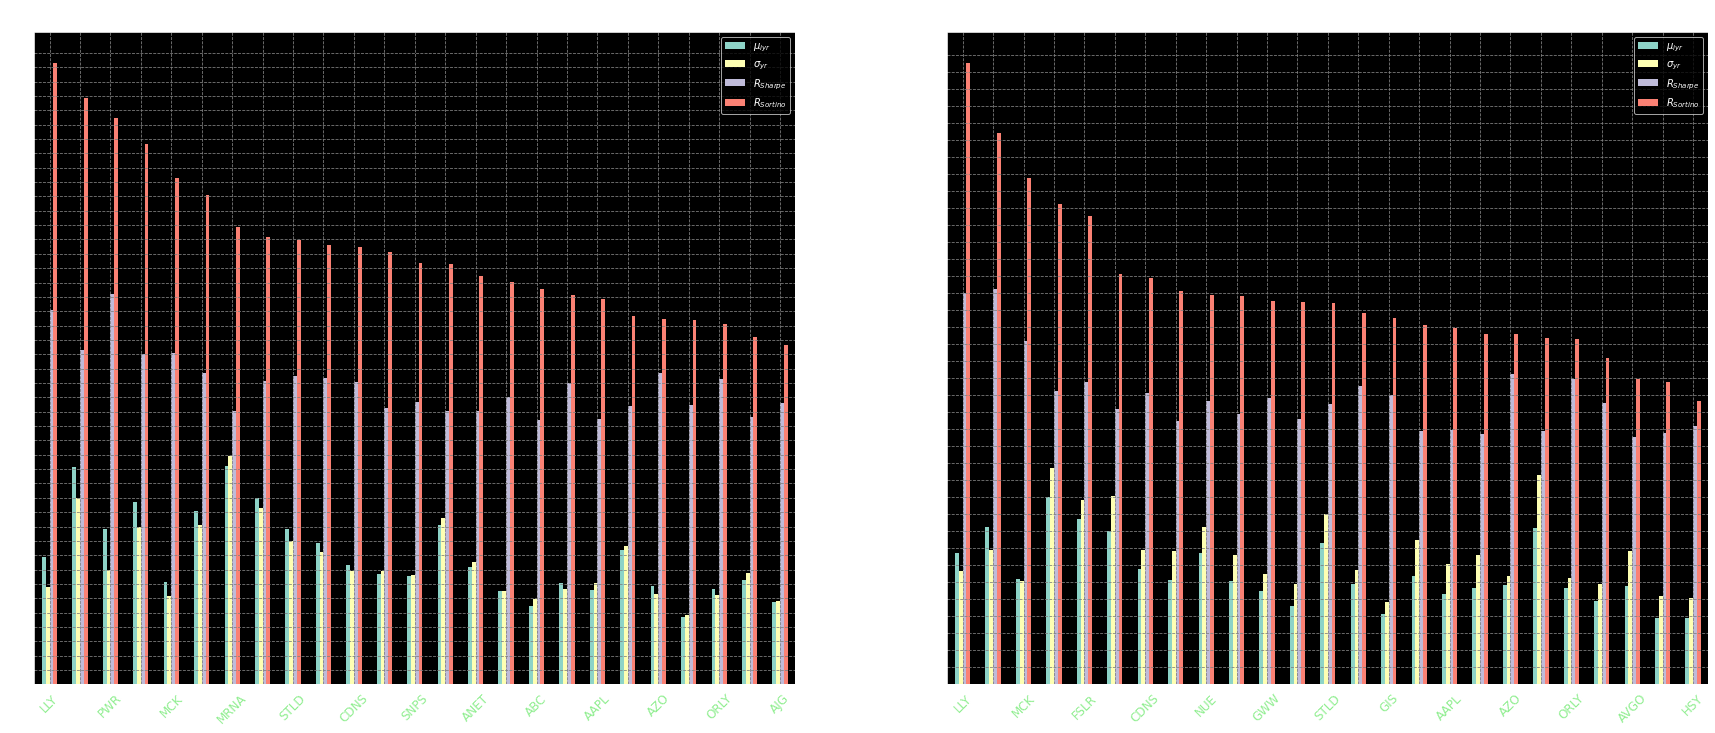

In [17]:
vs.Selection_R_SLog_Plot(SP_Assets_r, rf, best, start, execution_date, r_jump)

##### <font color= 'lightblue'> 2.2 <u> Modelling $X_i$ <u> <font>

In [ ]:
def Stats(dataframe, Selection, r, P, percentiles, dist, title, color):
    """
    Stats is a function that resamples data from a Selection performed over a dataframe.
    Parameters:
    ----------
    dataframe : dataframe
        Dataframe from which the Selection is made, in order to acess Selection's original data.
    Selection : list
        Selection to Resample for given period(s) etc. basis whose period is longer than original data.
    r : str
        Type of return for the model: "Simple" (multiplicative) or "Log" (additive).
    P : str
        Period of Resample (e.g. "W" for Weekly, "M" for Monthly, "3T" for Trimestral, "Q" for Quarterly,
        "Y" for Yearly, etc. for Dataframe.resample (see refs.).
    percentiles : list
        List of Returns of Percentiles returned by vs.Stats[0] dataframe (e.g. [.05, .25, .5, .75, .95]).
    dist : list
        Continuous Distributions to fit on datasets Xi
    title : str
        Title of the Box-plot
    color : str
        Color of the Box-plot.
    Returns:
    -------
    describe : dataframe
        Stats returns summary statistics (mean, std, min, max, percentiles, skewness and kurtosis) in a 
        markdown object callable as a dataframe by assigning a variable to the function in pos. [2].  
    """
    
    if  r == "Simple" :
        Selection = (dataframe[Selection.index].pct_change()).iloc[1:, :].dropna(axis = 1)
    if  r == "Log" :
        Selection = np.log(dataframe[Selection.index]).diff().iloc[1:, :].dropna(axis = 1)
    if r != "Simple" and r != "Log" :
        print("Aborted: Please select a valid Return type: 'Simple' or 'Log'. Stats help command: help(vs.Stats)")
    
    Selection.index = pd.to_datetime(Selection.index)
    Selection_Mo_r = Selection.resample(P).agg(lambda x: x[-1])
    Selection_Mo_r.plot(kind = "box", figsize = (22, 13), title = title, color = color, fontsize = 13)
    
    for i in range(0, len(Selection_Mo_r.columns)):
        plt.text(x = i + 0.96 , y = Selection_Mo_r.iloc[:, i].mean() + .0075, s = str("$\mu$ = +") + str(round(Selection_Mo_r.iloc[:, i].mean(), 4)), fontsize = 6.5, fontweight = "bold", color = "lightgreen")
        plt.text(x = i + 0.98 , y = Selection_Mo_r.iloc[:, i].max() + .010, s = str("+") + str(round(Selection_Mo_r.iloc[:, i].max(), 3)), fontsize = 8.5, color = "green")
        plt.text(x = i + 0.98 , y = Selection_Mo_r.iloc[:, i].min() - .015, s = str(round(Selection_Mo_r.iloc[:, i].min(), 3)), fontsize = 8.5, color = "red")

    describe = Selection_Mo_r.describe(percentiles)
    describe["mode"] = Selection_Mo_r.mode().iloc[0, :]
    describe["skewness"] = st.skew(Selection_Mo_r)
    describe["kurtosis"] = st.kurtosis(Selection_Mo_r)
    describe.replace("\n", "")

    dist_fit = np.empty(len(Selection_Mo_r.columns), dtype=object)
    
    for i in range(0, len(Selection.columns)):
        f = Fitter(pd.DataFrame(Selection_Mo_r.iloc[:, i]), distributions = dist, timeout=5)
        f.fit()
        params, AIC, BIC = [StringIO() for i in range(3)]
        (print(f.get_best(), file=params)), (print(f.get_best(method="aic"), file=AIC)), (print(f.get_best(method="bic"), file=BIC))
        params, AIC, BIC = [i.getvalue() for i in [params, AIC, BIC]]
        dist_fit[i] = (params + AIC + BIC).replace("\n", ", ")
    
    plt.title(title, fontsize = 20)
    plt.axhline(0, color = "red", lw = .5, linestyle = "--")
    plt.axhspan(0, Selection_Mo_r.min().min(), facecolor = "red", alpha = 0.2) 
    plt.axhspan(0, Selection_Mo_r.max().max(), facecolor = "green", alpha = 0.2)

    plt.xticks(rotation = 45)
    for i, t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if (i % 2) != 0:
            t.set_color("lightgreen")
        else:
            t.set_color("white")
            
    plt.yticks(np.arange(round(Selection_Mo_r.min().min(), 1), round(Selection_Mo_r.max().max(), 1), 0.05))
    plt.grid(alpha = 0.5, linestyle = "--", color = "grey")
    IPython.core.display.clear_output() 
    return describe, dist_fit, plt.show()

In [ ]:
Sortino25[2]

In [ ]:
Selection.tail()

In [ ]:
(SP_Assets_r.loc[start:today][Sortino25[2].index]).pct_change().iloc[1:, :].dropna(axis = 1).tail()

In [ ]:
np.log(SP_Assets_r.loc[start:today][Sortino25[2].index]).diff().iloc[1:, :].dropna(axis = 1).tail()

In [ ]:
SP_Assets_r.loc[start:today], Sortino25[2]

In [ ]:
dist=([d for d in dir(st) if isinstance(getattr(st, d), getattr(st, "rv_continuous"))])[0:60]

def ret(dataframe, selection, r):
    if  r == "Simple" :
        returns = (dataframe[selection.index]).pct_change().iloc[1:, :].dropna(axis = 1)
    if  r == "Log" :
        returns = np.log(dataframe[selection.index]).diff().iloc[1:, :].dropna(axis = 1)   
    if r != "Simple" and r != "Log" :
        print("Aborted: Please select a valid Return type: 'Simple' or 'Log'. selection_data help command: help(vs.selection_data)")
    
    returns.index = pd.to_datetime(returns.index)
    returns_Mo_r = returns.resample("M").agg(lambda x: x[-1])
    returns_Mo_r.plot(kind = "box", figsize = (22, 13), title = "test", color = "yellow", fontsize = 13)

    return returns, returns_Mo_r.max()

ret(SP_Assets_r.loc[start:today], Sortino25[2], "Simple")[1]


#Selection.index = pd.to_datetime(Sortino25[2].index)
# Selection_Mo_r = Selection.resample(P).agg(lambda x: x[-1])
# Selection_Mo_r.plot(kind = "box", figsize = (22, 13), title = title, color = color, fontsize = 13)

# for i in range(0, len(Selection_Mo_r.columns)):
#     plt.text(x = i + 0.96 , y = Selection_Mo_r.iloc[:, i].mean() + .0075, s = str("$\mu$ = +") + str(round(Selection_Mo_r.iloc[:, i].mean(), 4)), fontsize = 6.5, fontweight = "bold", color = "lightgreen")
#     plt.text(x = i + 0.98 , y = Selection_Mo_r.iloc[:, i].max() + .010, s = str("+") + str(round(Selection_Mo_r.iloc[:, i].max(), 3)), fontsize = 8.5, color = "green")
#     plt.text(x = i + 0.98 , y = Selection_Mo_r.iloc[:, i].min() - .015, s = str(round(Selection_Mo_r.iloc[:, i].min(), 3)), fontsize = 8.5, color = "red")

# describe = Selection_Mo_r.describe(percentiles)
# describe["mode"] = Selection_Mo_r.mode().iloc[0, :]
# describe["skewness"] = st.skew(Selection_Mo_r)
# describe["kurtosis"] = st.kurtosis(Selection_Mo_r)
# describe.replace("\n", "")

# dist_fit = np.empty(len(Selection_Mo_r.columns), dtype=object)

# for i in range(0, len(Selection.columns)):
#     f = Fitter(pd.DataFrame(Selection_Mo_r.iloc[:, i]), distributions = dist, timeout=5)
#     f.fit()
#     params, AIC, BIC = [StringIO() for i in range(3)]
#     (print(f.get_best(), file=params)), (print(f.get_best(method="aic"), file=AIC)), (print(f.get_best(method="bic"), file=BIC))
#     params, AIC, BIC = [i.getvalue() for i in [params, AIC, BIC]]
#     dist_fit[i] = (params + AIC + BIC).replace("\n", ", ")

# plt.title(title, fontsize = 20)
# plt.axhline(0, color = "red", lw = .5, linestyle = "--")
# plt.axhspan(0, Selection_Mo_r.min().min(), facecolor = "red", alpha = 0.2) 
# plt.axhspan(0, Selection_Mo_r.max().max(), facecolor = "green", alpha = 0.2)

# plt.xticks(rotation = 45)
# for i, t in enumerate(plt.gca().xaxis.get_ticklabels()):
#     if (i % 2) != 0:
#         t.set_color("lightgreen")
#     else:
#         t.set_color("white")
        
# plt.yticks(np.arange(round(Selection_Mo_r.min().min(), 1), round(Selection_Mo_r.max().max(), 1), 0.05))
# plt.grid(alpha = 0.5, linestyle = "--", color = "grey")
# plt.show()

$r_{Log}(X_i)$

In [ ]:
Selection = np.log(dataframe[Selection.index]).diff().iloc[1:, :].dropna(axis = 1)

In [ ]:
#Stats(dataframe, Selection, r, P, percentiles, dist, title, color):
describe_Wk = Stats(SP_Assets_r.loc[start:today], Sortino25[2], "Log", "W", [.025, .25, .5, .75, .95], dist, 
                    "$S&P$ 500 $r_{Log}(X_i)$ Selection Weekly Resampling from" + str(start) + "to" + str(today), "lightyellow")

In [ ]:
describe_Wk[0]

In [ ]:
describe_Mo = vs.Stats(SP_Assets_r.loc["2020-03-02":today], Sortino25[2], P[1][0],
                  "$X_i$ Selection Resamplings from $S&P$ 500 on a " + str(P[1][1]) + " basis from ", "2020-03-02", today,
                  [.025, .25, .5, .75, .95], dist, color=color[1])
                  

In [ ]:
describe_Mo[0]

In [ ]:
describe_Qt = vs.Stats(SP_Assets_r.loc["2020-03-02":today], Sortino25[2], P[2][0],
                  "$X_i$ Selection Resamplings from $S&P$ 500 on a " + str(P[2][1]) + " basis from ", "2020-03-02", today,
                  [.025, .25, .5, .75, .95], dist, color=color[2])

In [ ]:
describe_Qt[0]

##### <font color= 'black'> Estimators Parameters:
$f(X_i)$ and $AIC$ $\&$ $BIC$: <br>

Distributions and parameters that best estimate $f(X_i)$ are obtained from $104$ distribution classes and instances for continuous random variables in `Fitter` module  *(see refs.)*. <br>

The *$AIC$ Akaike $\&$ $BIC$ Bayesian Information Criterion* models are estimators of *relative quality* of predictions in the *Log-Likelihood* for fitted distributions.<br>
Minimum relative values for $AIC$ and $BIC$ are usually preferred and in this case, they are obtained to model $X_i$ resampled data on $W, M$   $\&$ $Q$ periods $P$.<br>
Criterion's goodness of fit is inversely related so they tend to be used together to avoid under/over fitting and they are defined as follows:
+ $AIC = 2k - 2ln(\hat{L})$<br>
+ $BIC = kln(n) - 2ln(\hat{L})$<br>

*where:*<br>

 $k$ = Params. in  model.<br>
 $n$ = No° of observations.<br>
 $\hat{L}$ = $Likelihood_{f_{max.}}$.<br>

In [ ]:
dist_fit=pd.DataFrame([describe_Wk[1], describe_Mo[1], describe_Qt[1]]).T
dist_fit_format = fn.format_table(dist_fit, Sortino25[2])
dist_fit_format

### <font color= 'blue'> 

### 3. Descriptive and Prescriptive Analytics for $X_P$ 

##### <font color= 'blue'> 3.1 <u>$X_P$<u> Optimizations Models <font>

<span style='color:gray'> *Equal weighted datasets are omitted from the analysis for simplicity purposes.*

<span style='color:black'>

If we have $n$ *unequally* weighted datasets $X_i=1,2,.., n$, to model $X_P$ we need $\mu_P$ $\&$ $\sigma_P$.<br>

And their weighted average is concluded:<br>

$$\mu_{P} = \frac{\sum_{i=1}^{n} w_{i} \mu_{{X_{i}}}}{\sum_{i=1}^{n} w_{i}}$$ 

If $$\sum_{i=1}^{n} w_{i} = 1$$ then: <br>

$$\mu_{P} = \sum_{i=1}^{n} w_{i} \mu_{{X_{i}}}$$ 

<span style='color:black'>

For the variance $\sigma^2_P$ we need to express $X_{i,j}$ as a matrix from the selection in $S\&P500$ *(A-Z)* quotes where ${\sigma_{i} \sigma_{j}}$ is the product of $X_{i,j}$ units of risk:<br>


$$\sigma_{i,j} = \left[\begin{array}{cccc}\sigma_{1} & \sigma_{1,2} & \cdots & \sigma_{1,500} \\ \sigma_{2,1} & \sigma_{2} & \cdots & \sigma_{2,500} \\ \vdots & \vdots & \ddots & \vdots \\ \sigma_{500,1} & \cdots & \cdots & \sigma_{500}\end{array}\right]$$

<span style='color:black'>

We also need $X_{i,j}$ correlation coefficients $\rho_{i j}$ = $\frac{Cov(X_i, X_{j})}{\sigma_{i} \sigma_{j}}$ or units of risk in $X_{i,j}$ that are not shared in their fluctuations directional relationship.<br>

Expressed and substituted as:

$$\sigma^2_P=\sum_{i=1}^{n}\sum_{j=1}^{n}w_{i}w_{j}\sigma_{i}\sigma_{j}\rho_{ij}$$ 

$$\sigma^2_P = \sum_{i=1}^{n}\sum_{j=1}^{n}w_{i}w_{j}Cov(X_i, X_j)$$

A product of matrices $\times$ vectors:<br>

$$\sigma^2_{P} = \vec{w}^T \times Cov_{i,j} \times \vec{w}$$

Reduced and expressed as the following in its expanded form:<br> 

$$\sigma^2_{P} = {\left[\begin{array}{cccc}w_{1} & w_{2} & \cdots & w_{n}\end{array}\right] \cdot \left[\begin{array}{cccc}1 & \rho_{1,2} & \cdots & \rho_{1,n} \\ \rho_{2,1} & 1 & \cdots & \rho_{2,n} \\ \vdots & \vdots & \ddots & \vdots \\ p_{n,1} & \cdots & \cdots & 1\end{array}\right] \cdot \left[\begin{array}{cccc}w_{1} \\ w_{2} \\ \vdots \\ w_{n}\end{array}\right]}$$


<span style='color:black'>

Now, the slope can be obtained from $X_{P}$ and $X_{S\&P500}$ which is expressed as:<br>

$\beta = \frac{Cov(r_P,r_{S\&P500})}{Var(r_{S\&P500})}$

To compute some metrics that include units of sensitivities the following are considered:<br>

+ $R_{Treynor} = \frac{Var(r_{S\&P500})(\mu_P - {rf})}{Cov(r_P,r_{S\&P500})}$<br>

or the *slope* per unit of $P$ excess returns over the risk-free.

+ $R_{Jensen}({r_P, r_{t_{S\&P500}}}) = (\mu_P - {rf}) - \frac{Cov(r_P,r_{t_{S\&P500}})}{Var(r_{t_{S\&P500}})}(\mu_{t_{S\&P500}} - {rf})$<br>

or excess returns of $P$ over the risk free minus the *slope* times $P$ excess returns of a benchmark over the risk-free.


<span style='color:black'>

Optimizations $\forall w_i$ are made with `Scipy` and validated with `Numpy` from parameters $X_i \rightarrow X_P$ for:<br><br>
+ $R_{Treynor_{Arg_{max}}}$
+ $R_{Sharpe_{Arg_{max}}}$
+ $R_{Sortino_{Arg_{max}}}$
+ $\sigma^2_{P_{Arg_{min}}}$

In [ ]:
def Optimizer(Assets, index, rf, title):
    Asset_ret = (Assets.pct_change()).iloc[1:, :].dropna(axis = 1)
    index_ret = index.pct_change().iloc[1:, :].dropna(axis = 1)
    index_ret = index_ret[index_ret.index.isin(Asset_ret.index)]

    mean_ret = Asset_ret.mean() * 252
    cov = Asset_ret.cov() * 252

    N = len(mean_ret)
    w0 = np.ones(N) / N
    bnds = ((0, None), ) * N
    cons = {"type" : "eq", "fun" : lambda weights : weights.sum() - 1}

    def Max_Sharpe(weights, Asset_ret, rf, cov):
        rp = np.dot(weights.T, Asset_ret)
        sp = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
        RS = (rp - rf) / sp
        return -(np.divide(np.subtract(rp, rf), sp))
    
    def Min_Var(weights, cov):
        return np.dot(weights.T, np.dot(cov, weights)) 
    
    def Min_Traynor(weights, Asset_ret, rf, cov):
        #(rp - rf) / Beta
        rp = np.dot(weights.T, Asset_ret)
        varp = np.dot(weights.T, np.dot(cov, weights))
        cov
        RT = (rp - rf) / sp
        return -(np.divide(np.subtract(rp, rf), sp))
    
    #-----------------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    opt_EMV = optimize.minimize(Max_Sharpe, w0, (mean_ret, rf, cov), 'SLSQP', bounds = bnds,
                                constraints = cons, options={"tol": 1e-10})
    
    W_EMV = pd.DataFrame(np.round(opt_EMV.x.reshape(1, N), 4), columns = Asset_ret.columns, index = ["Weights"])
    W_EMV[W_EMV <= 0.0] = np.nan
    W_EMV.dropna(axis = 1, inplace = True)

    RAssets = Asset_ret[Asset_ret.columns[Asset_ret.columns.isin(W_EMV.columns)]]
    # MuAssets = mean_ret[mean_ret.index.isin(W_EMV.columns)]
    R_EMV = pd.DataFrame((RAssets*W_EMV.values).sum(axis = 1), columns = ["$r_{Sharpe_{Arg_{max}}}$"])
    index_ret.rename(columns={index_ret.columns[0]: "$r_{mkt}$" }, inplace=True)
    R_EMV.insert(1, index_ret.columns[0], index_ret.values)

    Muopt_EMV = np.dot(opt_EMV.x.T, mean_ret) 
    Sopt_EMV = np.sqrt(np.dot(opt_EMV.x.T, np.dot(cov, opt_EMV.x)))
    Beta_EMV = np.divide((np.cov(R_EMV.iloc[0], R_EMV.iloc[1])[0][1]), R_EMV.iloc[1].var())
    SR_EMV = (Muopt_EMV - rf) / Sopt_EMV

    #-----------------------------------------------------------------------------------------------------------------------------------------------------------------------

    opt_MinVar = optimize.minimize(Min_Var, np.ones(N) / N, (cov,), 'SLSQP', bounds = bnds,
                                   constraints = cons, options={"tol": 1e-10})

    W_MinVar = pd.DataFrame(np.round(opt_MinVar.x.reshape(1, N), 4), columns = Asset_ret.columns, index = ["Weights"])
    W_MinVar[W_MinVar <= 0.0] = np.nan
    W_MinVar.dropna(axis = 1, inplace = True)

    RAssets_MinVar = Asset_ret[Asset_ret.columns[Asset_ret.columns.isin(W_MinVar.columns)]]
    R_MinVar = pd.DataFrame((RAssets_MinVar*W_MinVar.values).sum(axis = 1), columns = ["$r_{Var_{Arg_{min}}}$"])
    R_EMV.insert(2, R_MinVar.columns[0], R_MinVar.values)

    Muopt_MinVar = np.dot(opt_MinVar.x.T, mean_ret) 
    Sopt_MinVar = np.sqrt(np.dot(opt_MinVar.x.T, np.dot(cov, opt_MinVar.x)))
    Beta_MinVar = np.divide((np.cov(R_EMV.iloc[2], R_EMV.iloc[1])[0][1]), R_EMV.iloc[1].var())
    SR_MinVar = (Muopt_MinVar - rf) / Sopt_MinVar 

    #-----------------------------------------------------------------------------------------------------------------------------------------------------------------------
    #opt_Traynor = 
    
    #-----------------------------------------------------------------------------------------------------------------------------------------------------------------------

    Mu, Sigma, Beta, SR = [Muopt_EMV, Muopt_MinVar], [Sopt_EMV, Sopt_MinVar], [Beta_EMV, Beta_MinVar], [SR_EMV, SR_MinVar]
    index = ["$r_{P{Sharpe_{Arg_{max}}}}$", "$r_{Var_{Arg_{min}}}$"]
    Popt = [pd.DataFrame({"$\mu_P$" : Mu[i], "$\sigma_P$" : Sigma[i], "$\Beta_{P}$": Beta[i], "$r_{Sharpe_{Arg_{max}}}$" : SR[i]},
                          index = [index[i]]) for i in range(0, len(Mu))]
    
    Popt[0].index.name = title
    Popt[1].index.name = title
    R_EMV = R_EMV[[R_EMV.columns[1], R_EMV.columns[2], R_EMV.columns[0]]]
    #Get the cumulative returns with cumsum for rmkt, rEMV and rMinVar
    accum = R_EMV.cumsum()

    Argmax = [d.Markdown(tabulate(Popt[i], headers = "keys", tablefmt = "pipe")) for i in range(0, len(Popt))]
    R_EMV = d.Markdown(tabulate(R_EMV, headers = "keys", tablefmt = "pipe"))
    
    return Argmax, R_EMV, accum

In [ ]:
bench_md = "$S\&P500_{{20_{03}-23_{05}}}$"
Argmax, R_EMV, accum = vs.Optimizer(SP_Assets_r.loc["2020-03-02":today], SP_r.loc["2020-03-02":today], 0.0169, bench_md)

Port = display(Argmax[0], Argmax[1])

In [ ]:
d.Markdown(tabulate(accum.dropna()[0:10], headers = "keys", tablefmt = "pipe")) 
#Non sliced: d.Markdown(tabulate(accum.diff().dropna()[], headers = "keys", tablefmt = "pipe")) 

In [ ]:

d.display(d.Markdown(tabulate(accum[0:10], headers = "keys", tablefmt = "pipe")))

In [ ]:

d.display(d.Markdown(tabulate(accum[0:10], headers = "keys", tablefmt = "pipe")))


In [ ]:
vs.Accum_ts(accum)

##### <font color= 'blue'> Metrics: <font>

<span style='color:black'>

Confusion Matrix: $\begin{bmatrix} TP & FP \\ FN & TN \end{bmatrix}$

Metrics:

- Accuracy: $\frac{TP + TN}{TP + TN + FP + FN}$ or the ability of the classifier to find + and - samples.

- Precision: $\frac{TP}{TP + FP}$ or the ability of the classifier not to label + samples as -.

- Recall: $\frac{TP}{TP + FN}$ or the ability of the classifier to find all + samples.

- F1 Score: $2 * \frac{Precision * Recall}{Precision + Recall}$ or Precision and Recall equilibrated score through the harmonic mean.    

- ROC AUC: $\frac{TPR}{FPR}$ or the ability of the classifier to find + samples and not - samples. Where a bigger number denotes a better model.<br><br><br>

#### <span style='color:lightyellow'> ~ *Past performance is not a guarantee of future results, the stock market tends to be irrational.* <font>

**Note:** Do not consider the results in this repository and its proceedures as an advice or recommendation.


#### <font color= 'gray'>*¿How to reach me?* <font>

[![Website](https://img.shields.io/badge/Website-1f07f5?style=flat-square&logo=google-chrome&logoColor=white)](https://estebanmqz.github.io/Portfolio/)
[![LinkedIn](https://img.shields.io/badge/LinkedIn-173de8?style=flat-square&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/esteban-m-653817205/)
[![E-mail](https://img.shields.io/badge/Business-Mail-083600?style=flat-square&logo=mail&logoColor=white)](mailto:esteban@esteban.com)
[![Github](https://img.shields.io/badge/GitHub-100000?style=flat-square&logo=github&logoColor=white)](https://github.com/EstebanMqz)